In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# In order to do this part, we have to know what our tables look like, columns and types. Use Inspector.

inspector = inspect(engine)

In [10]:
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')
start_date = end_date - dt.timedelta(days=365)
print(start_date)




2016-08-23 00:00:00


In [20]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
one_year_data = session.query(*sel).filter(Measurement.date >= start_date).all()


In [21]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(one_year_data, columns=['Date','Precipitation'])
precipitation_df = precipitation_df.dropna(how='any')

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(["Date"], ascending=True)
precipitation_df = precipitation_df.set_index("Date")
precipitation_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15


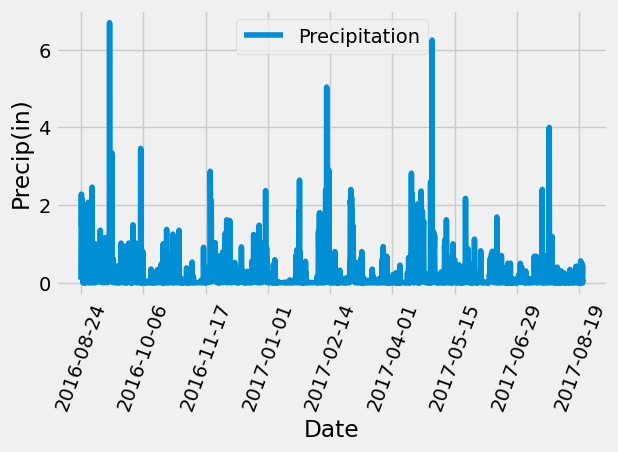

In [24]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Precip(in)')
plt.tight_layout()
plt.show()


In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(distinct(Measurement.station))).all()

[(9,)]

In [27]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]  #select stmt for station and quantity of data points
active_stations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()  #This is just simply doing a group by and order by on sel.
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# I believe "tobs" means "temperature observation", or an event of recording temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_numbers = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_numbers:
    print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# twelve_months_tobs = session.query(Measurement.date, Measurement.tobs).\
#     filter(Measurement.station == 'USC00519281').\
#     filter(Measurement.date > '2016-08-24').all()


sel = [Measurement.date, 
       Measurement.tobs]
twelve_month_tobs = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= '2016-08-24', Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

twelve_month_tobs_df = pd.DataFrame(twelve_month_tobs, columns=['Measurement Date', 'Temperature'])
twelve_month_tobs_df 



,Measurement Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


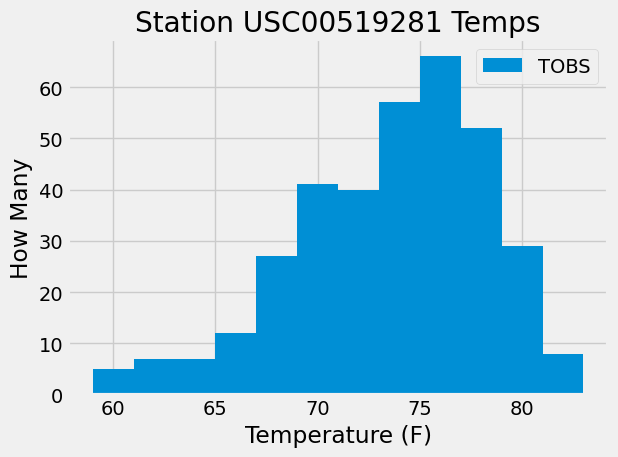

In [34]:
# Create a histogram to visualize the temperature observations from Station USC00519281 

plt.hist(twelve_month_tobs_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature (F)")
plt.ylabel("How Many")
plt.legend()
plt.title("Station USC00519281 Temps")
plt.figsize=(10,7)
plt.tight_layout()
#plt.savefig('Annual_Temps_USC00519281.png',bbox_inches='tight')
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()